<a href="https://colab.research.google.com/github/cr0wley-zz/Embeddings/blob/main/Glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data = """
My name is Devjyoti. Your name is Aritra. Aritra loves coding. Devjyoti Loves Sleeping. Aritra loves cricket. Devjyoti loves watching movies. Aritra likes 
western movies. Devjyoti likes eastern movies. 
"""

In [3]:
def word_processor(data):
  # Converts the data into tokens
  tokenized_text = tf.keras.preprocessing.text.text_to_word_sequence(data)
  tokenized_text_size = len(tokenized_text)
  # Creates a vocab of unique words
  vocab = sorted(set(tokenized_text))
  vocab_size = len(vocab)
  # Map the vocab words to individual indices
  vocab_to_ix = {c:ix for ix,c in enumerate(vocab)}
  # Map the indices to the words in vocab
  ix_to_vocab = np.array(vocab)
  # Convert the data into numbers
  text_as_int = np.array([vocab_to_ix[c] for c in tokenized_text])
  return vocab ,vocab_size, vocab_to_ix, ix_to_vocab, text_as_int

In [13]:
def compute_co_occurrence_matrix(corpus, window_size=1):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

      Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
            number of co-occurring words.
            
            For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
            "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

      Params:
          corpus (list of list of strings): corpus of documents
          window_size (int): size of context window
      Return:
          M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
              Co-occurence matrix of word counts. 
              The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
          word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    vocab ,vocab_size, vocab_to_ix, ix_to_vocab, text_as_int  = word_processor(corpus)
    
    

    # ------------------
    # Write your implementation here.
    M = np.zeros((vocab_size, vocab_size))

    doc_len =  len(text_as_int)
    for current_idx in range(doc_len):
      left_boudary = max(current_idx-window_size, 0)
      right_boundary = min(current_idx+window_size+1, doc_len)
      outside_words = np.append(text_as_int[left_boudary:current_idx],text_as_int[current_idx+1:right_boundary])
      center_word = text_as_int[current_idx]
      
      
      for outside_word in outside_words:
          M[center_word, outside_word] += 1.0
      
      current_idx += 1
    # ------------------

    return M, vocab_to_ix, vocab_size, ix_to_vocab




In [14]:
co_occurance_matrix ,vocab_to_ix, vocab_size, ix_to_vocab  = compute_co_occurrence_matrix(data, 1)

In [7]:
probability_matrix = co_occurance_matrix/co_occurance_matrix.sum(axis = 0)

In [8]:
EMBEDDING_SIZE = 2
context_vector =  tf.Variable(np.random.rand(vocab_size, EMBEDDING_SIZE))
center_vector = tf.Variable(np.random.rand(vocab_size, EMBEDDING_SIZE))
bias_center = tf.Variable(np.random.rand(vocab_size, 1))
bias_context = tf.Variable(np.random.rand(vocab_size, 1))

In [9]:
def weighted_func(x):
  return np.power((x/100), (3/4)) if x< 100 else 1

In [10]:
def train_step(indices, loss_list):
  """The training step

  Arguments:
    indices (list): The indices of the vocab in the window
  """
  cost = tf.Variable(0.0, dtype=tf.float64)
  with tf.GradientTape() as tape:
     for i in indices:
       for j in indices:
         prod = tf.tensordot(center_vector[i], context_vector[j], axes=1)
         bias = bias_center[i][0] + bias_context[j][0]
         cost = cost + weighted_func(co_occurance_matrix[i,j])*(prod + bias + tf.math.log(1+co_occurance_matrix[i,j])**2)
  
  loss_list.append(cost)
  grad = tape.gradient(cost, [context_vector, center_vector, bias_center, bias_context])
  opt.apply_gradients(zip(grad, [context_vector, center_vector, bias_center, bias_context]))

In [11]:
opt = tf.keras.optimizers.Adam()
loss_list = []
batch_size = 10
iterations = 1000
for iter in tqdm(range(iterations)):
  indices = np.random.randint(low=0, high=vocab_size, size=batch_size)
  train_step(indices, loss_list)

100%|██████████| 1000/1000 [05:03<00:00,  3.29it/s]


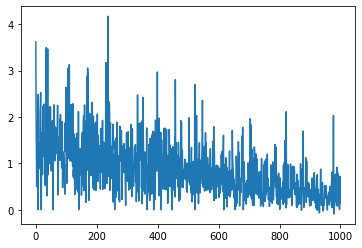

In [12]:
plt.plot(loss_list)